In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb
os.chdir(main)
%run stdPlotting.ipynb
os.chdir(d['py'])
from mCGE import CGE_OPT as CGE

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb2.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.


# Identify optimal regulation:

*Load model:*

In [2]:
vName, t0 = 'vDPRCG', 2019
name = '_'.join([vName, str(t0), 'CGE','calibration'])
M = CGE.load(os.path.join(d['data'], name))
db = M.db.copy() # store baseline model for later

Check if we can shock the model with taxes:

In [3]:
M.db.aom(M.db('tauD')+0.05, name = 'tauD')
M.db.mergeInternal()
test = M.solve(state = 'B')

### 1. Optimal regulation in steady state:

Allow the model to manipulate all output taxes (here specified as the rate on outputs from either production or household module):

In [4]:
instruments = ('or', [M.g('output', m = 'P'), M.g('L', m = 'HH')]) 
fullCondition = ('and', [instruments, M.g('tx2E')])
M.m['W'].endogenousPol = [('tauS', fullCondition)] # everything all at once
M.m['W'].initStuff() # re-initialize groups
M.opt = True
M.m['W'].active = True

C:\Users\sxj477\Anaconda3\envs\GAMS46\Lib\site-packages\pyDatabases\gpyDB\database.py:525: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  return ss.combine_first(s)


In [5]:
sol1 = M.solve(state='B')

Plot paths of taxes for labor and production. Add path for durables in the fourth panel:

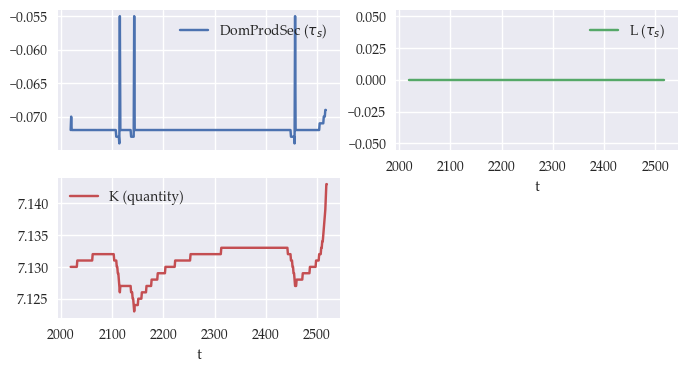

In [6]:
df = pd.concat([adj.rc_pd(sol1('tauS'), fullCondition).droplevel('s').unstack('n').rename(columns = lambda x: x+' ($\\tau_s$)'), 
               sol1('qD').xs(('DomProdSec','K'), level = ['s','n']).rename('K (quantity)')], axis = 1);
df.round(3).plot(subplots=True, figsize = (8,4), layout = (2,2));

### 2. Optimal regulation out of steady state:

Push the model out of steady state, e.g. by adjusting the rate of depreciation:

In [6]:
# M.db.aom(adj.rc_pd(M.db('rDepr'), ('and', [M.db('dur_p'), M.db('t0')])) * 0.95, name = 'rDepr')
# M.db.mergeInternal()

In [7]:
M.db.aom(adj.rc_pd(M.db('qD'), ('and', [M.db('dur_p'), M.db('t0')])) * 0.99, name = 'qD')
M.db.mergeInternal()

Solve:

In [8]:
sol2 = M.solve(state='B')

Check optimal solution again (same plot as above):

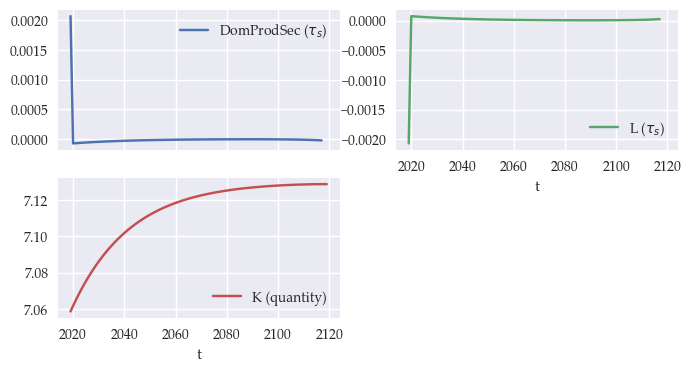

In [9]:
df = pd.concat([adj.rc_pd(sol2('tauS'), fullCondition).droplevel('s').unstack('n').rename(columns = lambda x: x+' ($\\tau_s$)'), 
           sol2('qD').xs(('DomProdSec','K'), level = ['s','n']).rename('K (quantity)')], axis = 1)
df.plot(subplots=True, figsize = (8,4), layout = (2,2));

Solve the model again without the "optimal taxes" to compare path of durables in this case:

In [10]:
M.opt = False
M.m['W'].active = False
sol3 = M.solve(state='B')

Compare path of durables:

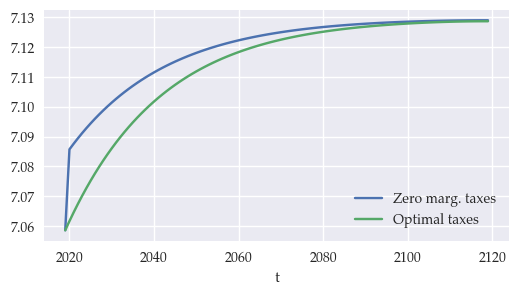

In [11]:
pd.concat([sol3('qD').xs(('DomProdSec','K'), level = ['s','n']).rename('Zero marg. taxes'),
           sol2('qD').xs(('DomProdSec','K'), level = ['s','n']).rename('Optimal taxes')], axis = 1).plot(figsize=(6,3));

### 3. Out of steady state, but with permanent interventions only:

Adjust model to include policy rule - e.g. that production subsidies remain constant over time.

In [11]:
from gmsPython.gmsWrite import Syms 
m = M.m['W'] # get welfare module
M.opt = True # add NLP solver again
m.active = True
# write block of equations
policyRule = f"""
$BLOCK B_{m.name}_polRule
    E_{m.name}_tauS[t,s,n]{Syms.gpyCondition(fullCondition)}.. tauS[t,s,n]  =E= tauSconst[s,n];
$ENDBLOCK
"""
# add initial level of new variable to database:
M.db.aom(pd.Series(0, index = adj.rc_pd(pd.MultiIndex.from_product([M.db('s'), M.db('n')]), instruments)), name = 'tauSconst')

Definition of groups and text blocks are defined as properties that, by default, are not mutable. However, we can make them mutable by simply calling ```makePropertyDynamic``` method (NOTE: calling this method adjusts the class method, so other instances of the same class are affected as well).

*Adjust equation text:*

In [12]:
k = 'equationText'
value = m.equationText+policyRule
m.makePropertyDynamic(k, value)

*adjust what model blocks are included in the final model:*

In [13]:
k = 'model_B'
value = m.model_B+OrdSet([f"B_{m.name}_polRule"]) # add new block of equations to be solved
m.makePropertyDynamic(k,value)

*Adjust the policy instruments that are endogenous in the optimization stage:*

In [14]:
M.m['W'].endogenousPol = [('tauS', ('and', [('or', [M.g('output', m = 'P'), M.g('L', m = 'HH')]),
                                            M.g('tx2E')])),
                          ('tauSconst', instruments)] # everything all at once
M.m['W'].initStuff() # re-initialize groups

Solve again:

In [15]:
soldbPermanent = M.solve(state='B')

The taxes are still not zero in this case:

In [16]:
soldbPermanent('tauSconst')

s           n         
DomProdSec  DomProdSec    0.000940
HH          L            -0.000941
Name: tauSconst, dtype: float64